In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
SR = 1000
#x = np.linspace(np.pi, 7*np.pi, SR)
x = np.linspace(0, 10, SR)

noise = np.random.uniform(-1.,1., SR)      
y1 = np.sin(x)# + 0.04*noise 
y2 = np.sin(5*x)
y = np.sin(5*x) *0.5*np.sin(20*x) * 0.2*np.sin(60*x)# + 0.001*noise 


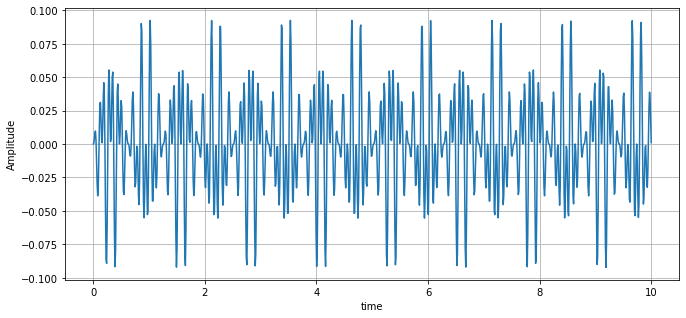

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
plt.ylabel('Amplitude')
plt.xlabel('time')
plt.grid(True, which='both')
plt.plot(x, y, label='orig')
#plt.plot(x, s, label='recovery')


In [4]:
N = SR
spectrum = np.fft.rfft(y)
orig = spectrum.copy()
freq = np.fft.rfftfreq(N, 1./SR)/4 #Frequency axis
spectrum = 1/N * np.abs(spectrum)
spectrum[1:] = spectrum[1:]*2

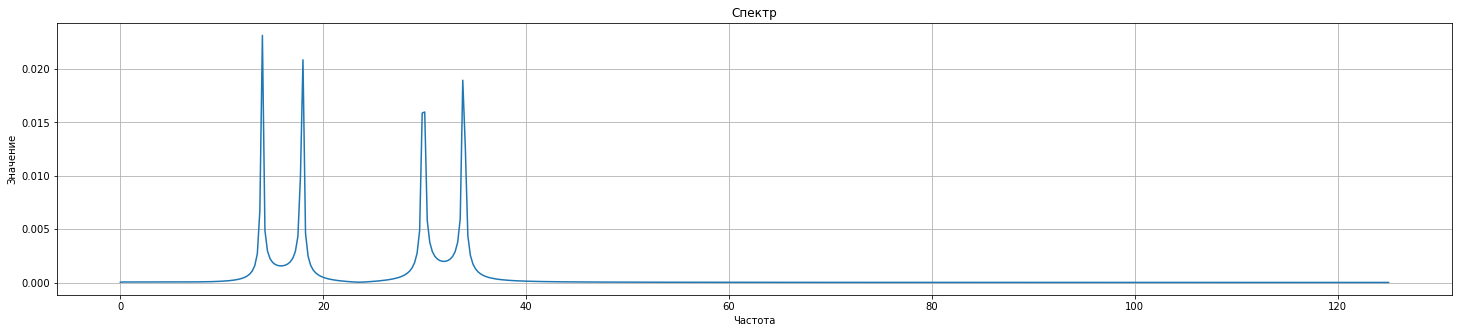

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
plt.plot(freq, spectrum)
# rfftfreq сделает всю работу по преобразованию номеров элементов массива в частоту
# интересует только спектр амплитуд, поэтому используем abs из numpy (действует на массивы поэлементно)
# делим на число элементов, чтобы скорректировать амплитуду. Постоянные составляющие должны совпадать в смоделированном гармоническом сигнале и в спектре
plt.xlabel(u'Частота')
plt.ylabel(u'Значение')
plt.title(u'Спектр')
plt.grid(True)
plt.show()

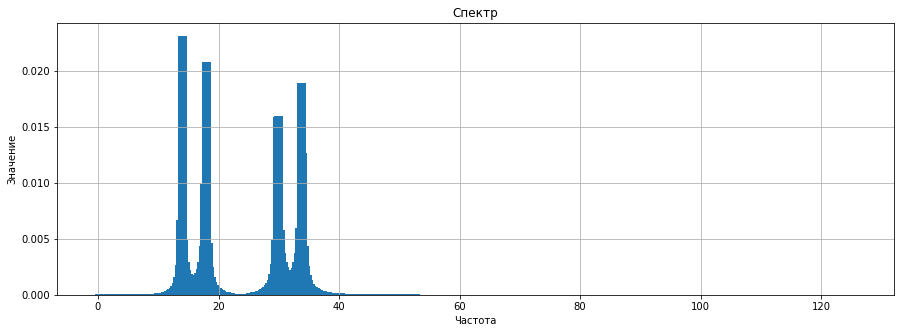

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
plt.bar(freq[1:], spectrum[1:] , width=1.5)
plt.xlabel(u'Частота')
plt.ylabel(u'Значение')
plt.title(u'Спектр')
plt.grid(True)
plt.show()

In [7]:
s = np.fft.irfft(orig)

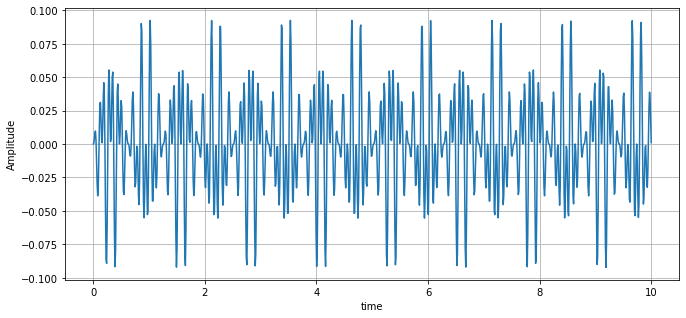

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
plt.ylabel('Amplitude')
plt.xlabel('time')
plt.grid(True, which='both')
plt.plot(x, s, label='recovery')

In [9]:
orig_wo_noise = spectrum.copy()
orig_wo_noise[orig_wo_noise < 0.04] = 0.

orig_wo_noise.shape, spectrum.shape

((501,), (501,))

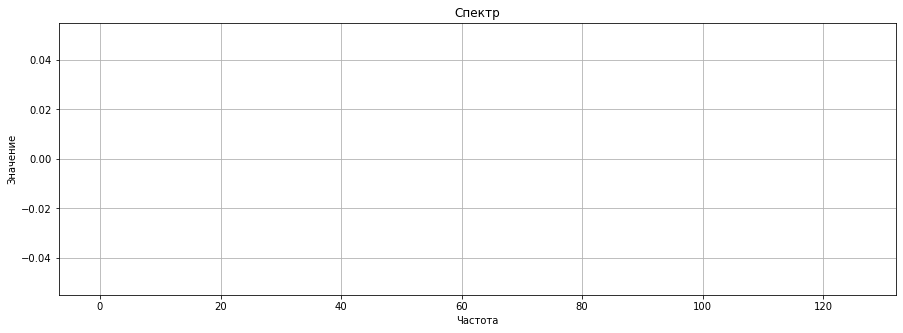

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.bar(freq[1:], orig_wo_noise[1:] , width=1.5)
plt.xlabel(u'Частота')
plt.ylabel(u'Значение')
plt.title(u'Спектр')
plt.grid(True)
plt.show()

In [11]:
s_ = np.fft.irfft(orig_wo_noise)

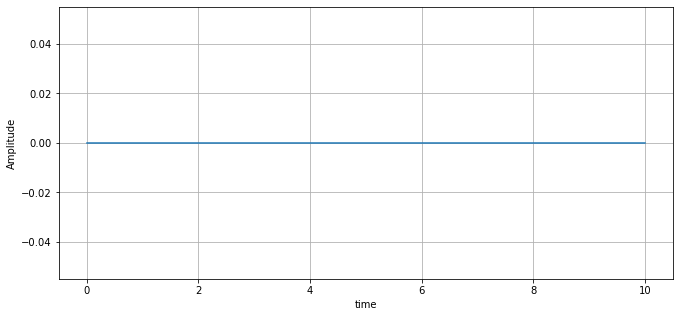

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
plt.ylabel('Amplitude')
plt.xlabel('time')
plt.grid(True, which='both')
plt.plot(x, s_, label='recovery')


In [309]:
y1 = np.zeros((1000, 1))
y2 = np.cos(3*x)

In [310]:
print(y1.shape, y2.shape)
y12 = np.column_stack((y1, y2))
y12.shape

(1000, 1) (1000,)


(1000, 2)

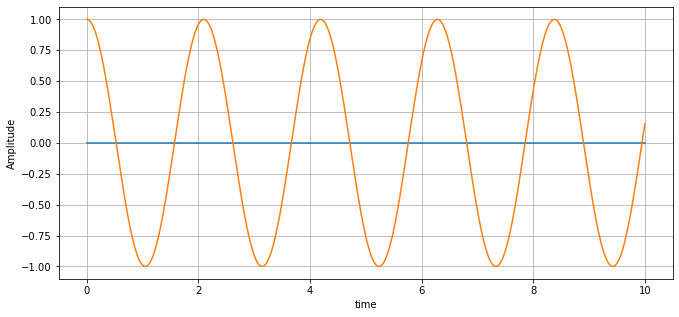

In [311]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
plt.ylabel('Amplitude')
plt.xlabel('time')
plt.grid(True, which='both')
plt.plot(x, y12[:,0], label='recovery')
plt.plot(x, y12[:,1], label='recovery')

In [312]:
y_ = y1.reshape(100,10)

In [313]:
y_ = y12.reshape(100,10,2)

In [314]:
y12.shape, y_.shape

((1000, 2), (100, 10, 2))

In [315]:
import tensorflow as tf
import keras
import keras.models as M
import keras.layers as L
import keras.activations
import keras.backend as K
from keras.callbacks import Callback
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model
print(tf.test.gpu_device_name())
print(tf.__version__)
print(keras.__version__)

/device:GPU:0
2.3.1
2.4.3


In [391]:
from keras.regularizers import L1L2

def create_sparse_ae():
    
    encoding_dim = 4
    lambda_l1 = 1e-9
    
    # Энкодер
    input_img = Input(shape=(10,2))
    flat_img = Flatten()(input_img)
    x = Dense(encoding_dim*3, activation='elu')(flat_img)
    x = Dense(encoding_dim*2, activation='elu')(x)
    encoded = Dense(encoding_dim, activation='linear', activity_regularizer=L1L2(lambda_l1))(x)
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim*2, activation='elu')(input_encoded)
    x = Dense(encoding_dim*3, activation='elu')(x)
    flat_decoded = Dense((20), activation='elu')(x)
    decoded =  Dense((20), activation='linear')(flat_decoded)
    decoded = Reshape((10,2))(decoded)
    
    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="s_autoencoder")
    return encoder, decoder, autoencoder

s_encoder, s_decoder, s_autoencoder = create_sparse_ae()
#s_autoencoder.compile(optimizer='adam', loss='mse')
s_autoencoder.summary()

Model: "s_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_88 (InputLayer)        [(None, 10, 2)]           0         
_________________________________________________________________
encoder (Functional)         (None, 4)                 392       
_________________________________________________________________
decoder (Functional)         (None, 10, 2)             828       
Total params: 1,220
Trainable params: 1,220
Non-trainable params: 0
_________________________________________________________________


In [392]:
s_autoencoder.compile(optimizer='sgd', loss='mse')
s_autoencoder.compile(optimizer='rmsprop', loss='mse')
s_autoencoder.compile(optimizer='adam', loss='mse')

In [393]:
s_autoencoder.fit(y_, y_,
                epochs=500,
                batch_size=50,
                shuffle=True)
                #validation_data=(X_norm_val, X_norm_val))

Epoch 1/500
2/2 [==============================] - 0s 0s/step - loss: 0.3531
Epoch 2/500
2/2 [==============================] - 0s 8ms/step - loss: 0.3215
Epoch 3/500
2/2 [==============================] - 0s 0s/step - loss: 0.2936
Epoch 4/500
2/2 [==============================] - 0s 0s/step - loss: 0.2700
Epoch 5/500
2/2 [==============================] - 0s 0s/step - loss: 0.2498
Epoch 6/500
2/2 [==============================] - 0s 0s/step - loss: 0.2326
Epoch 7/500
2/2 [==============================] - 0s 0s/step - loss: 0.2174
Epoch 8/500
2/2 [==============================] - 0s 8ms/step - loss: 0.2039
Epoch 9/500
2/2 [==============================] - 0s 0s/step - loss: 0.1916
Epoch 10/500
2/2 [==============================] - 0s 0s/step - loss: 0.1800
Epoch 11/500
2/2 [==============================] - 0s 8ms/step - loss: 0.1688
Epoch 12/500
2/2 [==============================] - 0s 8ms/step - loss: 0.1577
Epoch 13/500
2/2 [==============================] - 0s 0s/step - loss

2/2 [==============================] - 0s 0s/step - loss: 0.0074
Epoch 106/500
2/2 [==============================] - 0s 0s/step - loss: 0.0074
Epoch 107/500
2/2 [==============================] - 0s 0s/step - loss: 0.0073
Epoch 108/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0073
Epoch 109/500
2/2 [==============================] - 0s 0s/step - loss: 0.0072
Epoch 110/500
2/2 [==============================] - 0s 0s/step - loss: 0.0072
Epoch 111/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0071
Epoch 112/500
2/2 [==============================] - 0s 0s/step - loss: 0.0071
Epoch 113/500
2/2 [==============================] - 0s 0s/step - loss: 0.0070
Epoch 114/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0070
Epoch 115/500
2/2 [==============================] - 0s 0s/step - loss: 0.0069
Epoch 116/500
2/2 [==============================] - 0s 0s/step - loss: 0.0069
Epoch 117/500
2/2 [==============================] - 0s 8ms/ste

2/2 [==============================] - 0s 0s/step - loss: 0.0035
Epoch 208/500
2/2 [==============================] - 0s 0s/step - loss: 0.0034
Epoch 209/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 210/500
2/2 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 211/500
2/2 [==============================] - 0s 0s/step - loss: 0.0033
Epoch 212/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 213/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 214/500
2/2 [==============================] - 0s 0s/step - loss: 0.0033
Epoch 215/500
2/2 [==============================] - 0s 0s/step - loss: 0.0032
Epoch 216/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 217/500
2/2 [==============================] - 0s 0s/step - loss: 0.0032
Epoch 218/500
2/2 [==============================] - 0s 0s/step - loss: 0.0032
Epoch 219/500
2/2 [==============================] - 0s 8ms/s

2/2 [==============================] - 0s 0s/step - loss: 0.0017
Epoch 311/500
2/2 [==============================] - 0s 0s/step - loss: 0.0017
Epoch 312/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 313/500
2/2 [==============================] - 0s 0s/step - loss: 0.0016
Epoch 314/500
2/2 [==============================] - 0s 0s/step - loss: 0.0016
Epoch 315/500
2/2 [==============================] - 0s 0s/step - loss: 0.0016
Epoch 316/500
2/2 [==============================] - 0s 0s/step - loss: 0.0016
Epoch 317/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 318/500
2/2 [==============================] - 0s 0s/step - loss: 0.0016
Epoch 319/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 320/500
2/2 [==============================] - 0s 0s/step - loss: 0.0016
Epoch 321/500
2/2 [==============================] - 0s 0s/step - loss: 0.0015
Epoch 322/500
2/2 [==============================] - 0s 8ms/ste

2/2 [==============================] - 0s 0s/step - loss: 4.8831e-04
Epoch 412/500
2/2 [==============================] - 0s 8ms/step - loss: 4.7765e-04
Epoch 413/500
2/2 [==============================] - 0s 0s/step - loss: 4.6867e-04
Epoch 414/500
2/2 [==============================] - 0s 0s/step - loss: 4.6371e-04
Epoch 415/500
2/2 [==============================] - 0s 0s/step - loss: 4.5529e-04
Epoch 416/500
2/2 [==============================] - 0s 0s/step - loss: 4.4749e-04
Epoch 417/500
2/2 [==============================] - 0s 8ms/step - loss: 4.4343e-04
Epoch 418/500
2/2 [==============================] - 0s 4ms/step - loss: 4.3479e-04
Epoch 419/500
2/2 [==============================] - 0s 4ms/step - loss: 4.2630e-04
Epoch 420/500
2/2 [==============================] - 0s 0s/step - loss: 4.2111e-04
Epoch 421/500
2/2 [==============================] - 0s 8ms/step - loss: 4.1433e-04
Epoch 422/500
2/2 [==============================] - 0s 0s/step - loss: 4.0871e-04
Epoch 423/500

In [394]:
y__ = s_autoencoder.predict(y_)
y__ = y__.reshape(1000, 2)

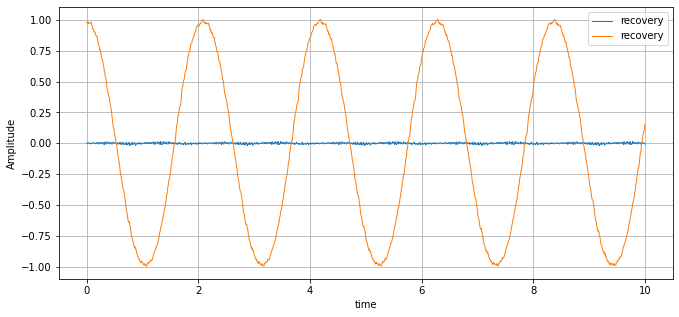

In [395]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
plt.ylabel('Amplitude')
plt.xlabel('time')
plt.grid(True, which='both')
#plt.plot(x, ф, label='recovery', lw=1)
plt.plot(x, y__[:,0], label='recovery', lw=1)
plt.plot(x, y__[:,1], label='recovery', lw=1)
#plt.plot( y_.flatten(), label='pure')
plt.legend()

In [404]:
y1 = np.zeros((1000, 1))
#y1 = np.cos(5*x)
y2 = np.sign(np.cos(3*x))

In [405]:
print(y1.shape, y2.shape)
y12_test = np.column_stack((y1, y2))
y_test = y12_test.reshape(100,10,2)

(1000, 1) (1000,)


In [406]:
y__test = s_autoencoder.predict(y_test)
y__test = y__test.reshape(1000, 2)

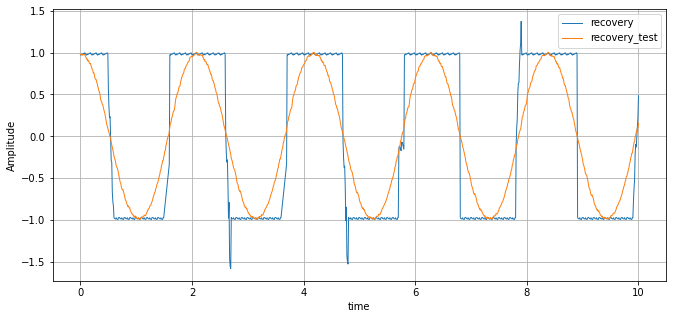

In [407]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
plt.ylabel('Amplitude')
plt.xlabel('time')
plt.grid(True, which='both')
plt.plot(x, y__test[:,1], label='recovery', lw=1)
plt.plot(x, y__[:,1], label='recovery_test', lw=1)
#plt.plot( y_.flatten(), label='pure')
plt.legend()